In [1]:
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
import yfinance as yf
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import statsmodels.api as sm
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import sys
import scipy
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage,fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import to_tree
from sklearn.cluster import DBSCAN
from scipy.sparse.linalg import eigsh

# 爬2005~2023的data

In [2]:
#S&P500
wikiurl="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)

soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find_all('table',{'class':"wikitable"})


df=pd.read_html(str(indiatable))

df=pd.DataFrame(df[0])
df = df.sort_values("Symbol")

all_symbol = " ".join(df["Symbol"].values)

tmp_info = yf.Tickers(all_symbol)
data = yf.download(all_symbol, start="2005-01-01", end="2023-12-31")

tmp_info = yf.Tickers(all_symbol)
data_info = pd.DataFrame([tmp_info.tickers[tmp_symbol].info for tmp_symbol in df["Symbol"].values])
data_info.index = df["Symbol"].values

data_daily_prices = data["Adj Close"]
tmp_na_count = data_daily_prices.isna().sum()
data_daily_prices2 = data_daily_prices.loc[:,tmp_na_count==0]
data_info2 = data_info.loc[tmp_na_count==0,:]

SP500_daily_price = data_daily_prices2
SP500_daily_returns = SP500_daily_price.pct_change()
SP500 = SP500_daily_returns.iloc[1:, :]

C:\Users\USER\AppData\Local\Temp\ipykernel_32068\502277147.py:10: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df=pd.read_html(str(indiatable))
[*********************100%%**********************]  503 of 503 completed

5 Failed downloads:
['GEV', 'SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1104555600, endDate = 1703998800")
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-01-01 -> 2023-12-31)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['LW']: ConnectionError(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out."))


In [6]:
SP500.to_csv("C:\\Users\\USER\\Desktop\\sp500_data.csv")

# 建立 Network


## Cov Netwrok

In [ ]:
SP500 = pd.read_csv

In [7]:
def adjacency(data,upper,lower):
  cor = data.corr()
  cor[(cor > 0) & (cor < upper)] = 0
  cor[(cor < 0) & (cor > lower)] = 0
  np.fill_diagonal(cor.values, 0)
  return cor

def create_mst(adjacency_matrix):
    if isinstance(adjacency_matrix, np.ndarray):
        adjacency_matrix = pd.DataFrame(adjacency_matrix)
        
    G = nx.Graph()
    for r in adjacency_matrix.index:
        for c in adjacency_matrix.columns:
            weight = adjacency_matrix.at[r, c]
            if weight != 0:
                G.add_edge(r, c, weight=weight)
    mst = nx.minimum_spanning_tree(G, algorithm='prim')
    return mst


In [31]:
adjs = []
years = SP500.index.year.unique()
rolling_years = [(years[i], years[i+1]) for i in range(len(years) - 1)]
rolling_years
for year in rolling_years:
    yearly_df = SP500[SP500.index.year.isin(year)]
    adj_matrix = adjacency(yearly_df, 0.6, -0.6)
    adjs.append(adj_matrix)

msts = []
for adj in adjs:
    msts.append(create_mst(adj))    

In [32]:
SP500_graph = pd.DataFrame(index=['isolated_nodes', 'edges'], columns= rolling_years)

for year, adj in zip(rolling_years, adjs):
    isolated_count = sum(np.all(adj == 0, axis=1))  
    edge_count = np.count_nonzero(adj) // 2 
    SP500_graph[year] = [isolated_count, edge_count]

SP500_graph

,"(2005, 2006)","(2006, 2007)","(2007, 2008)","(2008, 2009)","(2009, 2010)","(2010, 2011)","(2011, 2012)","(2012, 2013)","(2013, 2014)","(2014, 2015)","(2015, 2016)","(2016, 2017)","(2017, 2018)","(2018, 2019)","(2019, 2020)","(2020, 2021)","(2021, 2022)","(2022, 2023)"
isolated_nodes,266,246,69,59,85,42,60,163,160,114,110,160,138,110,21,20,56,59
edges,380,795,8618,9771,6952,20614,14348,1022,1312,2374,2174,989,1167,1734,14927,14477,3511,2975


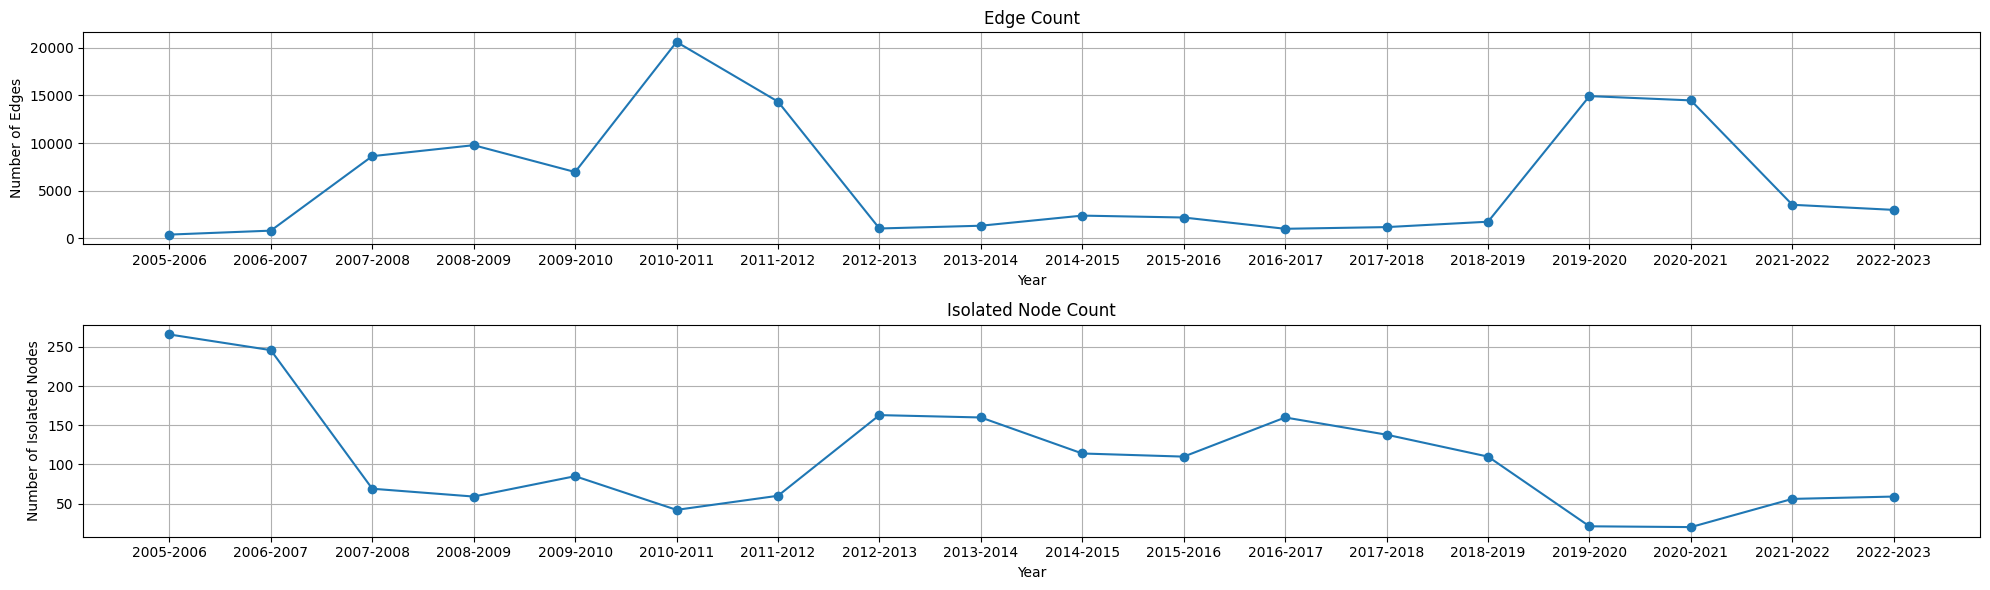

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6)) 
x_labels = [f'{start}-{end}' for start, end in SP500_graph.columns]

axes[0].plot(x_labels, SP500_graph.iloc[1,:], marker='o', linestyle='-')
axes[0].set_title("Edge Count")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Edges")
axes[0].grid(True)  

axes[1].plot(x_labels, SP500_graph.iloc[0,:], marker='o', linestyle='-')
axes[1].set_title("Isolated Node Count")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Number of Isolated Nodes")
axes[1].grid(True)  

fig.tight_layout() 
plt.show()

## MST

In [17]:
def plot_mst(mst, layout_type='spring', scale=1.0, community=None, conductance=None):
    plt.figure(figsize=(14, 10))
    
    #layout
    if layout_type == 'spring':
        pos = nx.spring_layout(mst, scale=scale)  
    elif layout_type == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(mst, scale=scale)  
    elif layout_type == 'spectral':
        pos = nx.spectral_layout(mst, scale=scale) 
    else:
        pos = nx.spring_layout(mst, scale=scale) 

    normal_nodes = [node for node in mst.nodes() if node not in community] if community else mst.nodes()
    nx.draw_networkx_nodes(mst, pos, nodelist=normal_nodes, node_size=500, node_color='skyblue', alpha=0.6)

    if community:
        nx.draw_networkx_nodes(mst, pos, nodelist=community, node_size=500, node_color='red', alpha=0.8)

    weights = nx.get_edge_attributes(mst, 'weight')
    all_weights = list(weights.values())
    max_weight = max(all_weights, default=1)  # Avoid division by zero if no edges
    min_weight = min(all_weights, default=0)
    width_scale = 10  # Scale factor for edge width
    edge_widths = [(weights.get(edge, 0) - min_weight + 0.1) / (max_weight - min_weight + 0.1) * width_scale for edge in mst.edges()]

    nx.draw_networkx_edges(mst, pos, width=edge_widths, edge_color='gray', alpha=0.5)
    nx.draw_networkx_labels(mst, pos, font_size=8, font_family="sans-serif")

    title = 'Minimum Spanning Tree Visualization'
    if conductance is not None:
        title += f' (Conductance: {conductance:.4f})'
    plt.title(title, size=15)
    
    plt.axis('off') 
    plt.show()


In [16]:
import plotly.graph_objects as go

def interactive_graph_plot(adj, community=None, conductance=None):
    if isinstance(adj, pd.DataFrame):
        labels = adj.index.tolist()
        G = nx.from_pandas_adjacency(adj)
    else:
        G = nx.from_numpy_array(adj)
        labels = list(range(len(adj)))

    centrality = nx.eigenvector_centrality_numpy(G)
    
    node_size = [max(v * 100, 10) for v in centrality.values()]
    pos = nx.spring_layout(G)  # Node position layout
    
    edge_x, edge_y, node_x, node_y = [], [], [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    node_color = []
    for node in G.nodes():
        node_x.append(pos[node][0])
        node_y.append(pos[node][1])
        if community and node in community:
            node_color.append('red')  # Community node color
        else:
            node_color.append('blue')  #other node color

    edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='gray'), mode='lines', hoverinfo='none')
    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', marker=dict(showscale=True, colorscale='YlGnBu', size=node_size, color=node_color, colorbar=dict(thickness=15, title='Node Centrality', xanchor='left', titleside='right'), line_width=2))

    node_text = [f'{labels[i]}<br>Centrality: {centrality[node]:.4f}' for i, node in enumerate(G.nodes())]
    node_trace.text = node_text

    title = '<br>Network graph by centrality'
    if conductance is not None:
        title += f' | Conductance: {conductance:.4f}'
    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(title=title, titlefont_size=16, showlegend=False, hovermode='closest', margin=dict(b=0, l=0, r=0, t=40), annotations=[dict(text="Python code: NetworkX+Plotly", showarrow=False, xref="paper", yref="paper", x=0.005, y=-0.002)], xaxis=dict(showgrid=False, zeroline=False, showticklabels=False), yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
    
    fig.show()

## Local Cluster

In [14]:
from scipy import sparse
from collections import deque


class MyGraph:
    """
    This class implements graph loading from an edge list,
    and provides methods that operate on the graph.

    ------------------------------------------------------------
    Attributes:

    _adjacency_matrix:
        scipy csr matrix (Compressed Sparse Row Matrix)
        use virtual node id as index

    _weighted: bool
        whether the graph is weighted

    _num_vertices: int
        the number of vertices(nodes)

    _num_edges: int
        the number of edges

    _degree: numpy array{float}
        degree of nodes, use virtual node id as index

    _dict_ori_node_id_to_vir_node_id: dict{string: int}
        assign original node id to virtual node id, make sure that id is from 0 to n-1
        this dict return the virtual node id of original node id

    _dict_vir_node_id_to_ori_node_id: dict{int: string}
        assign original node id to virtual node id, make sure that id is from 0 to n-1
        this dict return the original node id of virtual node id
    ------------------------------------------------------------
    Functions:

    read_graph(self, file_name, file_type='edge_list', separator='\t', comment='#')
        read a graph from a file, and initialize the attributes

    approximate_ppr(self, seed_set, alpha=0.15, epsilon=1e-5)
        approximate personalized PageRank vector of the graph

    sweep_with_conductance(self, score, window=3)
        return the best community with the local minimal conductance

    local_community_detection_pagerank_nibble(self, seed_set, alpha=0.15, epsilon=1e-5, window=3)
        Use PageRank Nibble algorithm to find the local community of the seed set.
    ------------------------------------------------------------
    """

    def __init__(self,
                 file_name=None,
                 file_type='edge_list',
                 separator='\t',
                 comment='#'):
        """
        initialize the MyGraph class.

        :param file_name: string
            input file path for building the graph.

        :param file_type: string
            the file type for the input file, currently only support 'edge list'
            Default: 'edge_list'

        :param separator: string
            the separator used in the input file
            Default: '\t'

        :param comment: string
            identifier of the comment
            Default: '#'
        """

        # before initialize, set all attributes to None or Empty
        self._adjacency_matrix = None
        self._weighted = None
        self._num_vertices = None
        self._num_edges = None
        self._degree = None
        self._dict_ori_node_id_to_vir_node_id = dict()
        self._dict_vir_node_id_to_ori_node_id = dict()

        if file_name is None:
            raise Exception('MyGraph.__init__: Edge list file for building graph is None.')

        self.read_graph(file_name, file_type=file_type, separator=separator, comment=comment)

    def read_graph(self,
                   file_name,
                   file_type='edge_list',
                   separator='\t',
                   comment='#'):
        """
        read the graph from input file

        :param file_name: string
            input file path for building the graph.

        :param file_type: string
            the file type for the input file, currently only support 'edge list'
            Default: 'edge_list'

        :param separator: string
            the separator used in the input file
            Default: '\t'

        :param comment: string
            identifier of the comment
            Default: '#'

        :return: None

        """

        if file_type == 'edge_list':
            graph_df = pd.read_csv(file_name, delimiter=separator, comment=comment, header=None)

            if graph_df.shape[1] == 2:
                self._weighted = False
            elif graph_df.shape[1] == 3:
                self._weighted = True
            else:
                raise Exception('MyGraph.read_graph: graph_df.shape[1] not in (2, 3)')

            ori_src = graph_df[0].values
            ori_dst = graph_df[1].values

            vir_src = list()
            vir_dst = list()

            # use virtual node id to replace original node id
            # make sure that virtual node_id is from 0 to n-1
            next_virtual_id = 0
            for ori_node in ori_src:
                if ori_node not in self._dict_ori_node_id_to_vir_node_id:
                    self._dict_ori_node_id_to_vir_node_id[ori_node] = next_virtual_id
                    self._dict_vir_node_id_to_ori_node_id[next_virtual_id] = ori_node
                    next_virtual_id += 1
                vir_src.append(self._dict_ori_node_id_to_vir_node_id[ori_node])
            for ori_node in ori_dst:
                if ori_node not in self._dict_ori_node_id_to_vir_node_id:
                    self._dict_ori_node_id_to_vir_node_id[ori_node] = next_virtual_id
                    self._dict_vir_node_id_to_ori_node_id[next_virtual_id] = ori_node
                    next_virtual_id += 1
                vir_dst.append(self._dict_ori_node_id_to_vir_node_id[ori_node])

            if self._weighted:
                weights = graph_df[2].values
            else:
                weights = np.ones(ori_src.shape[0])

            self._num_vertices = len(self._dict_vir_node_id_to_ori_node_id)
            self._adjacency_matrix = sparse.csr_matrix((weights.astype(np.float64),
                                                        (vir_src, vir_dst)),
                                                       shape=(
                                                           self._num_vertices, self._num_vertices))

            is_symmetric = (self._adjacency_matrix != self._adjacency_matrix.T).sum() == 0
            if not is_symmetric:
                # make the matrix symmetric, new_adj = adj + adj.T
                self._adjacency_matrix = self._adjacency_matrix + self._adjacency_matrix.T
                assert (self._adjacency_matrix != self._adjacency_matrix.T).sum() == 0, \
                    'MyGraph.read_graph: the adjacency matrix is not symmetric.'

            self._num_edges = self._adjacency_matrix.nnz / 2
            self._degree = np.ravel(self._adjacency_matrix.sum(axis=1))
        else:
            raise Exception('MyGraph.read_graph: The type of the input file is not supported '
                            'currently.')

    def approximate_ppr(self,
                        seed_set,
                        alpha=0.15,
                        epsilon=1e-5):
        """
        Compute the approximate Personalized PageRank (PPR) from a set of seed node.

        This function implements method introduced by Andersen et al. in
        "Local Graph Partitioning using PageRank Vectors", FOCS 2006.
        and adjust weighted graph

        :param seed_set: list/set
            list or set of seed node(s)

        :param alpha: float
            Teleportation constant
            alpha corresponds to the probability for the random walk to restarts from the seed set
            Default: 0.15

        :param epsilon: float
            Precision parameter for the approximation
            Default: 1e-5

        :return: numpy 1D array{float}
            Vector containing the approximate PPR for each node of the graph.
        """

        # initialize the ppr vector and residual vector
        ppr = np.zeros(self._num_vertices)
        residual = np.zeros(self._num_vertices)

        # initialize the value of seed(s)
        vir_seed_list = list()
        for seed in seed_set:
            vir_seed_list.append(self._dict_ori_node_id_to_vir_node_id[seed])
        residual[vir_seed_list] = 1. / len(vir_seed_list)

        # initialize push node queue
        push_queue = deque(vir_seed_list)

        # push procedure
        while len(push_queue) > 0:
            cur_node_id = push_queue.pop()
            push_val = residual[cur_node_id] - 0.5 * epsilon * self._degree[cur_node_id]
            residual[cur_node_id] = 0.5 * epsilon * self._degree[cur_node_id]
            ppr[cur_node_id] += alpha * push_val
            put_val = (1. - alpha) * push_val
            for neighbor in self._adjacency_matrix[cur_node_id].indices:
                old_res = residual[neighbor]
                residual[neighbor] += \
                    put_val * self._adjacency_matrix[cur_node_id, neighbor] \
                    / self._degree[cur_node_id]
                threshold = epsilon * self._degree[cur_node_id]
                if residual[neighbor] >= threshold > old_res:
                    push_queue.appendleft(neighbor)

        return ppr

    def sweep_with_conductance(self, score, window=3):
        """
        Return the best community with the local minimal conductance

        This function implements method introduced by Andersen et al. in
        "Local Graph Partitioning using PageRank Vectors", FOCS 2006.

        :param score: numpy array{float}
            The fitness score used to sort nodes in the graph

        :param window: int
            Window parameter used for the detection of a local minimum of conductance,
            means after local minim, there are {window} number greater than it,
            should greater than 1
            Default: 3

        :return: set(int), float
            return the community set, and the corresponding conductance
        """

        total_volume = np.sum(self._degree)
        sorted_nodes = [node for node in range(self._num_vertices) if score[node] > 0]

        if len(sorted_nodes) == 0:
            print ("PPR score are all zero.")
            return set(), 0.0

        sorted_nodes = sorted(sorted_nodes, key=lambda tmp_node: score[tmp_node], reverse=True)
        sweep_set = set()
        cur_volume = 0.
        cur_cut = 0.
        
        best_conductance = float('inf')
        best_sweep_set = {sorted_nodes[0]}
        increase_count = 0
        for cur_node in sorted_nodes:
            cur_volume += self._degree[cur_node]
            for neighbor in self._adjacency_matrix[cur_node].indices:
                if neighbor in sweep_set:
                    cur_cut -= self._adjacency_matrix[cur_node, neighbor]
                else:
                    cur_cut += self._adjacency_matrix[cur_node, neighbor]
            sweep_set.add(cur_node)

            if cur_volume == total_volume:
                break
            conductance = cur_cut / min(cur_volume, total_volume - cur_volume)
            if conductance < best_conductance:
                best_conductance = conductance
                # Make a copy of the set
                best_sweep_set = set(sweep_set)
                increase_count = 0
            else:
                increase_count += 1
                if increase_count >= window:
                    break

        # set node id to integer
        best_sweep_set = map(int, best_sweep_set)

        return best_sweep_set, best_conductance

    def local_community_detection_pagerank_nibble(self,
                                                  seed_set,
                                                  alpha=0.15,
                                                  epsilon=1e-5,
                                                  window=3):
        """
        Use PageRank Nibble algorithm to find the local community of the seed set.

        :param seed_set: list/set
            list or set of seed node(s)

        :param alpha: float
            Teleportation constant
            alpha corresponds to the probability for the random walk to restarts from the seed set
            Default: 0.15

        :param epsilon: float
            Precision parameter for the approximation
            Default: 1e-5

        :param window: int
            Window parameter used for the detection of a local minimum of conductance,
            means after local minim, there are {window} number greater than it,
            should greater than 1
            Default: 3

        :return: set(int), float
            return the community set, and the corresponding conductance
        """

        print ("---\nBegin Local Community Detection")

        # if seed not in the graph
        for seed in seed_set:
            if seed not in self._dict_ori_node_id_to_vir_node_id:
                print ('Some seed is not contained in the graph')
                empty_result = set()
                return empty_result, 0.0

        # approximate PageRank value
        ppr = self.approximate_ppr(seed_set, alpha=alpha, epsilon=epsilon)
        # sweep to detect the community
        vir_community_set, conductance = self.sweep_with_conductance(ppr, window=window)

        ori_community_set = set()
        for vir_node_id in vir_community_set:
            ori_community_set.add(self._dict_vir_node_id_to_ori_node_id[vir_node_id])

        print ("Finished Local Community Detection")
        print ("---\n")

        return ori_community_set, conductance

In [19]:
def plot_community(i,seed_set):
    G = nx.from_pandas_adjacency(adjs[i])
    edge_list = nx.to_pandas_edgelist(G)
    edge_list.to_csv('graph_edge_list.csv', index=False, header=False)

    my_graph = MyGraph(file_name='graph_edge_list.csv', separator=',')
    community1, conductance1 = my_graph.local_community_detection_pagerank_nibble(seed_set)

    print(rolling_years[i],len(community1))
    plot_mst(msts[i], layout_type='kamada_kawai', scale=.1,community = community1, conductance = conductance1) 
    interactive_graph_plot(adjs[i],community = community1, conductance = conductance1)

---
Begin Local Community Detection
Finished Local Community Detection
---

(2006, 2007) 30


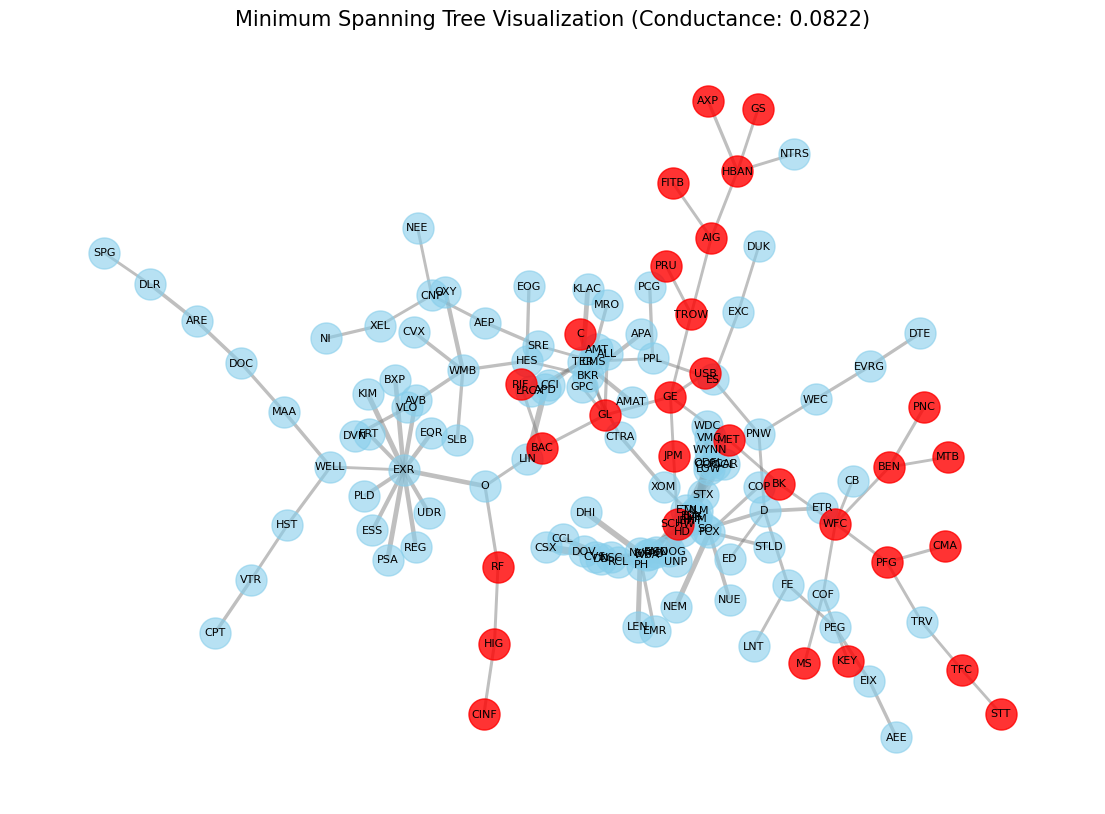

In [33]:
plot_community(i = 1,seed_set={'JPM', 'BAC','GS','C'})

In [ ]:
seed_set = {'JPM', 'BAC','GS','C'}

communitys = []
conductances = []
for i in range(0,len(adjs)):
    G = nx.from_pandas_adjacency(adjs[i])
    edge_list = nx.to_pandas_edgelist(G)
    edge_list.to_csv('graph_edge_list.csv', index=False, header=False)

    my_graph = MyGraph(file_name='graph_edge_list.csv', separator=',')

    community1, conductance1 = my_graph.local_community_detection_pagerank_nibble(seed_set)
    communitys.append(community1)
    conductances.append(conductance1)

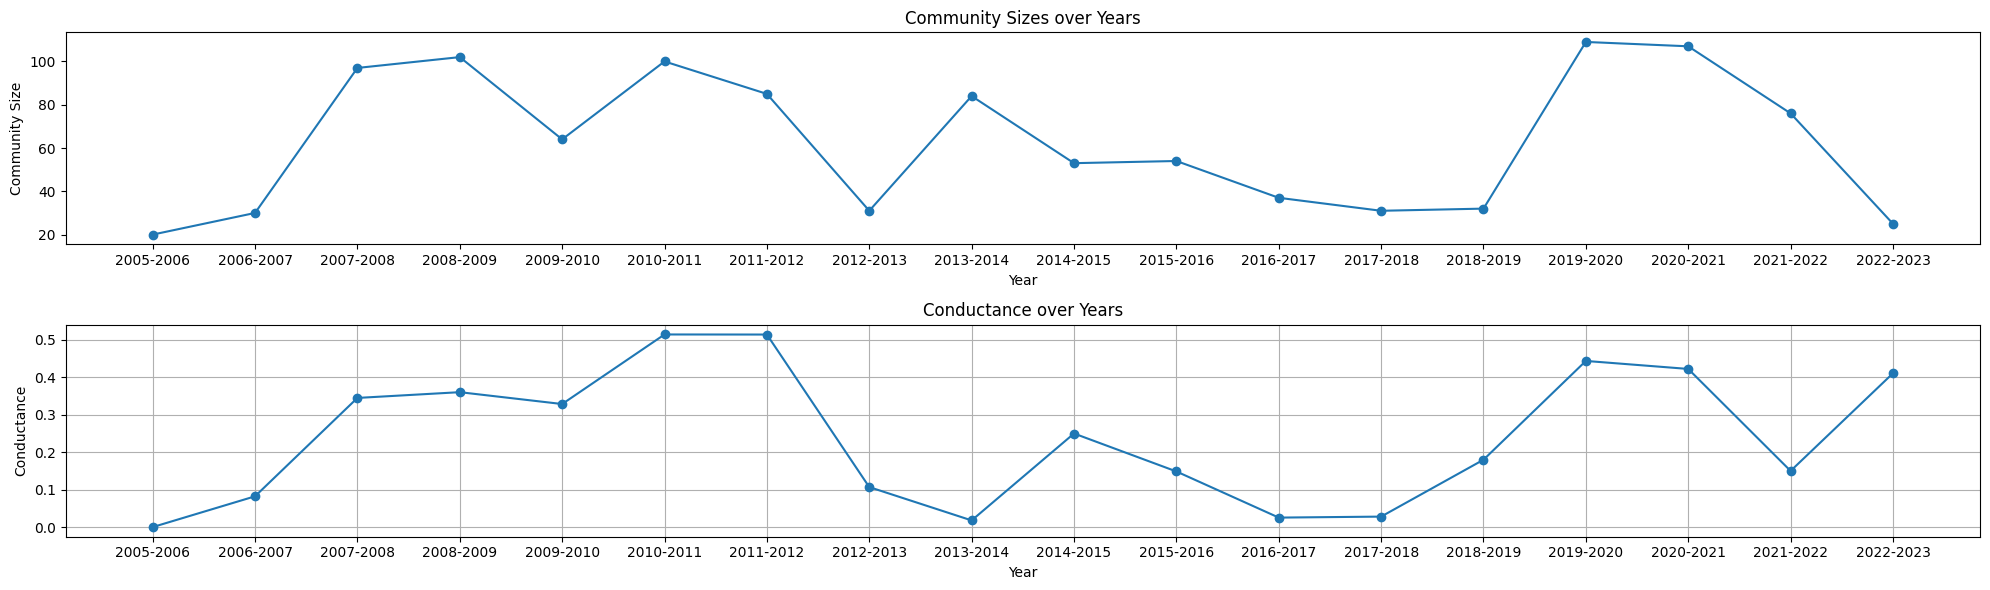

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6)) 

community_sizes = [len(community) for community in communitys]

axes[0].plot(x_labels, community_sizes, marker='o', linestyle='-')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Community Size')
axes[0].set_title('Community Sizes over Years')

axes[1].plot(x_labels, conductances, marker='o', linestyle='-')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Conductance')
axes[1].set_title('Conductance over Years')
axes[1].grid(True)


fig.tight_layout() 
plt.show()